# Chapter 4: Acceralation of word2vec

The problem of word2vec which implemented previous chapter is that it would be slow if the courpus is huge. So, we need to improve word2vec.

## 4.1 word2vec improvement : Embedding class

forward method of Embedding class just extract the word vector which associated  with current id from the weight matrix.


In [1]:
import numpy as np

W = np.arange(21).reshape(7, 3)

print(W)
print(W[2])

idx = np.array([1, 0, 2])
print(W[idx])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
[6 7 8]
[[3 4 5]
 [0 1 2]
 [6 7 8]]


In [2]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        # np.add.at(dW, self.idx, dout)
        # return None
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]
        return None

## 4.2 word2vec improvement : Negative sampling

### 4.2.1 calculation problem after middle layer

When the corpus size is huge, calculation takes time in following process.

- the product of the neurons of the hidden layer and the weight matrix
- calculation of Softmax layer

For example, softmax is shown as following assuming that the corpus size is 100,000.

$$
y = \frac{\exp(x_i)}{\sum_j^{1000000} \exp(x_j)}
$$

### 4.2.2 Negative sampling

To reduce the calculation problem, we use negative sampling in which we randomly select negative samples from the corpus.

### 4.2.3 Sigmoid function and Cross entropy error

Sigmoid function and Cross entropy error are shown as following.

Sigmoid:
$$
y = \frac{1}{1 + e^{-x}}
$$

Cross entropy error:
$$
L = -(t \log y + (1 - t) \log (1 - y))
$$

![../images/4.2.3.png](./fig/4_2_3.drawio.svg)

### 4.2.4 From multiclass classification to binary classification

![img](./fig/4_2_4.drawio.svg)


In [3]:
# embedding dot class
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [4]:
import numpy as np
W = np.arange(21).reshape(7, 3)
h = np.arange(9).reshape(3, 3)
idx = np.array([0, 3, 1])

embed = Embedding(W)
target_W = embed.forward(idx)
out = np.sum(target_W * h, axis=1)

print(out.reshape(out.shape[0], 1))
print(target_W)
print(h)

[[  5]
 [122]
 [ 86]]
[[ 0  1  2]
 [ 9 10 11]
 [ 3  4  5]]
[[0 1 2]
 [3 4 5]
 [6 7 8]]


### 4.2.5 Negative sampling

Negative sampling is learning correct words with some sample incorrect words.
Normally 5 ~ 10 negtive samples are randomly selected from the corpus.
This is the reason to be called Negative sampling.

### 4.2.6 Sampling method of Negative sampling

when we use negative sampling, we use appearance probability of the word in the corpus.

$$
P'(W_i) = \frac{P(W_i)^{0.75}}{\sum_j^{n} P(W_j)^{0.75}}
$$

In [5]:
import numpy as np

np.random.choice(10)

words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
print(np.random.choice(words))
print(np.random.choice(words))

print(np.random.choice(words, size=3))
print(np.random.choice(words, size=3, replace=False))

# use probability
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
print(np.random.choice(words, p=p))
print(np.random.choice(words, p=p))
print(np.random.choice(words, p=p))
print(np.random.choice(words, p=p))
print(np.random.choice(words, p=p))

p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

say
you
['say' 'you' 'say']
['hello' 'goodbye' '.']
you
you
goodbye
I
goodbye
[0.64196878 0.33150408 0.02652714]


In [6]:
# 4.2.6 Negative sampling
GPU = False

import collections

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [9]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
counts = collections.Counter()

for word_id in corpus:
    counts[word_id] += 1

In [34]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)

print(negative_sample)


[[4 3]
 [2 4]
 [3 1]]


### 4.2.7 Implementation of Negative sampling

In [11]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

In [7]:
# Class NegativeSamplingLoss
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 1.正例の評価
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 2.負例の評価
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
            
        return dh




## 4.3 Learning of improved word2vec

### 4.3.1 implementation of CBOW model


In [8]:
import sys
import numpy as np

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None


### 4.3.2 Learning of CBOW


| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 0[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 1[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 1[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 2[s] | loss 3.92
| epoch 1 |  iter 121 / 9295 | time 2[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 2[s] | loss 3.63
| epoch 1 |  iter 161 / 9295 | time 3[s] | loss 3.48
| epoch 1 |  iter 181 / 9295 | time 3[s] | loss 3.35
| epoch 1 |  iter 201 / 9295 | time 4[s] | loss 3.24
| epoch 1 |  iter 221 / 9295 | time 4[s] | loss 3.17
| epoch 1 |  iter 241 / 9295 | time 4[s] | loss 3.07
| epoch 1 |  iter 261 / 9295 | time 5[s] | loss 3.01
| epoch 1 |  iter 281 / 9295 | time 5[s] | loss 2.94
| epoch 1 |  iter 301 / 9295 | time 6[s] | loss 2.91
| epoch 1 |  iter 321 / 9295 | time 6[s] | loss 2.88
| epoch 1 |  iter 341 / 9295 | time 6[s] | loss 2.82
| epoch 1 |  iter 361 / 9295 | time 7[s] | loss 2.81

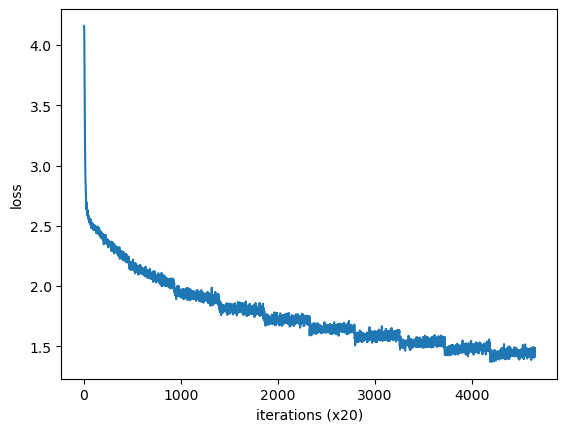

In [12]:
# Learning of CBOW
GPU = False

import sys
sys.path.append("../.org/deep-learning-from-scratch-2/")
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# Hyper parameters
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# Load corpus
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexttm, target = create_contexts_target(corpus, window_size)
if GPU:
    contexttm = to_gpu(contexttm)
    target = to_gpu(target)

# Create model
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# Training
trainer.fit(contexttm, target, max_epoch, batch_size)
trainer.plot()

# save data
word_vecs = model.word_vecs
if GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)


### 4.3.3 Testing of CBOW model

In [13]:
import sys
sys.path.append("../.org/deep-learning-from-scratch-2/")
from common.util import most_similar
import pickle


pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.76025390625
 i: 0.68896484375
 your: 0.63134765625
 they: 0.58349609375
 anything: 0.57666015625

[query] year
 month: 0.84033203125
 summer: 0.7890625
 spring: 0.77978515625
 week: 0.77978515625
 decade: 0.69189453125

[query] car
 truck: 0.60205078125
 window: 0.59423828125
 luxury: 0.58935546875
 cars: 0.56689453125
 auto: 0.5615234375

[query] toyota
 honda: 0.65234375
 nissan: 0.64208984375
 mazda: 0.63720703125
 motor: 0.62255859375
 minicomputers: 0.607421875


In [21]:
from common.util import cos_similarity

print(word_to_id["you"])
print(word_vecs[(word_to_id["you"]),:])

print(word_to_id["i"])
print(word_vecs[(word_to_id["i"]),:])

cos_similarity(word_vecs[(word_to_id["you"]),:], word_vecs[(word_to_id["year"]),:])

316
[-0.5312   0.4575  -1.173   -1.28     2.566   -0.1176  -0.324   -0.269
 -2.074    1.507    0.2262  -1.129    0.1704  -0.4583  -0.3774   1.527
 -2.213    0.0639  -0.812   -0.1112   0.386    0.3208  -0.9717   0.1511
 -1.515    0.2491  -0.375    0.4612  -1.104    0.684    0.622   -0.77
  0.294   -0.805    0.3657  -0.4216  -1.184   -0.666    0.1037   0.6797
  0.6895  -1.915    1.022   -0.3389  -0.814   -0.5713  -0.9165  -0.8345
  1.343   -0.388   -0.5684  -1.778   -1.201    1.59    -0.946   -0.1375
 -0.1006   0.04816  0.2484  -0.3464  -0.06714 -0.4504  -1.788   -0.463
  0.433   -0.6426  -0.61    -0.708    1.022    1.032   -0.2015   0.9614
 -0.1702   0.1406  -0.9517   0.435   -0.6533   1.687   -0.8154   0.2673
  1.111    0.846   -1.219    0.6772  -0.8057  -0.5903   1.975    0.766
  0.04108 -0.2426   0.719   -0.1978  -1.496   -0.911   -0.4246   0.9336
  0.0717   0.0498   0.9136   0.2974 ]
1040
[-0.1798    0.6133   -0.2764    0.3784    1.514     0.08044  -1.621
 -1.2295   -0.541     0.848

0.02425

In [23]:
from common.util import analogy

analogy('man', 'king', 'woman', word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs)


[analogy] man:king = woman:?
 horse: 3.876953125
 ton: 3.876953125
 weisfield: 3.826171875
 hat: 3.732421875
 award: 3.638671875

[analogy] take:took = go:?
 eurodollars: 5.53125
 a.m: 4.54296875
 went: 4.21875
 came: 4.21484375
 're: 4.1875

[analogy] car:cars = child:?
 a.m: 6.37890625
 children: 5.171875
 rape: 5.0
 incest: 4.8046875
 bond-equivalent: 4.6953125

[analogy] good:better = bad:?
 less: 5.75
 more: 5.6640625
 rather: 5.26953125
 greater: 4.53125
 worse: 4.03515625


## 4.4 Remained theme of CBOW

### 4.4.1 Application sample of word2vec

trained model of word2vec can be used to solve the analogy problem.
単語を固定長ベクトルに変換することで自然言語の様々なタスク(感情分析など)に使用することができる。

### 4.4.2 Evaluation method of word vector

実際のアプリケーションでは複数のシステムを組み合わせて作られる。

- 単語の分散表現の作成
- 特定の問題に対して分類を行う

2段階の機械学習を同時にチューニングするには多くの時間がかかるため、
分散表現の良さをアプリケーションと切り離して評価するのが一般的である。

